# Transfer Learning with ResNet50 for CIFAR-10 Classification

## Overview
This notebook implements transfer learning using a pre-trained ResNet50 model for CIFAR-10 classification. We compare this approach with the custom CNN to understand the trade-offs between training from scratch vs leveraging pre-trained models.

## Key Design Decisions
1. **Pre-trained Model**: ResNet50 trained on ImageNet (1000 classes)
2. **Architecture Adaptation**: Replace top layers for 10-class output
3. **Training Strategy**: Two-phase training (frozen then fine-tuning)
4. **Input Preprocessing**: Resize CIFAR-10 from 32x32 to 224x224

## Import Libraries and Set Configuration

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import time
import warnings
import gc
warnings.filterwarnings('ignore', message='.*PyDataset.*')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Clear any existing models from memory
tf.keras.backend.clear_session()
gc.collect()

# Configuration
CONFIG = {
    'batch_size': 16,
    'epochs_frozen': 10,
    'epochs_finetune': 20,
    'learning_rate_frozen': 0.001,
    'learning_rate_finetune': 0.0001,
    'patience': 5,
    'model_name': 'msc_ai_contardi_resnet50_cifar10'
}

print(f"\nTensorFlow Version: {tf.__version__}")
print(f"Batch size: {CONFIG['batch_size']}")


TensorFlow Version: 2.19.0
Batch size: 16


## Data Loading and Preprocessing

1. **Image resizing**: 32x32 → 224x224 (ResNet50 requirement)
2. **Preprocessing**: ResNet50-specific normalization
3. **Memory considerations**: Larger images = more memory usage, it was necessary the use of GPU

In [19]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(x_train_full, y_train_full), (x_test_orig, y_test_orig) = tf.keras.datasets.cifar10.load_data()

# Combine all data for custom splitting
x_all = np.concatenate([x_train_full, x_test_orig], axis=0)
y_all = np.concatenate([y_train_full, y_test_orig], axis=0).flatten()

# Create 70/15/15 split (same as CNN approach)
x_temp, x_test, y_temp, y_test = train_test_split(
    x_all, y_all, test_size=0.15, stratify=y_all, random_state=42
)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.15/0.85, stratify=y_temp, random_state=42
)

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nDataset splits (before resizing):")
print(f"Training: {len(x_train)} images")
print(f"Validation: {len(x_val)} images")
print(f"Test: {len(x_test)} images")
print(f"Original image size: {x_train[0].shape}")

Loading CIFAR-10 dataset...

Dataset splits (before resizing):
Training: 42000 images
Validation: 9000 images
Test: 9000 images
Original image size: (32, 32, 3)


## Image Preprocessing for ResNet50

- ResNet50 was trained on ImageNet with 224x224 images
- Using different size would break pre-trained weights


Preprocessing images for ResNet50 (in batches to save memory)...
Processing training set...
Processing validation set...
Processing test set...
Resized image shape: (224, 224, 3)
Memory usage increase: 49.0x


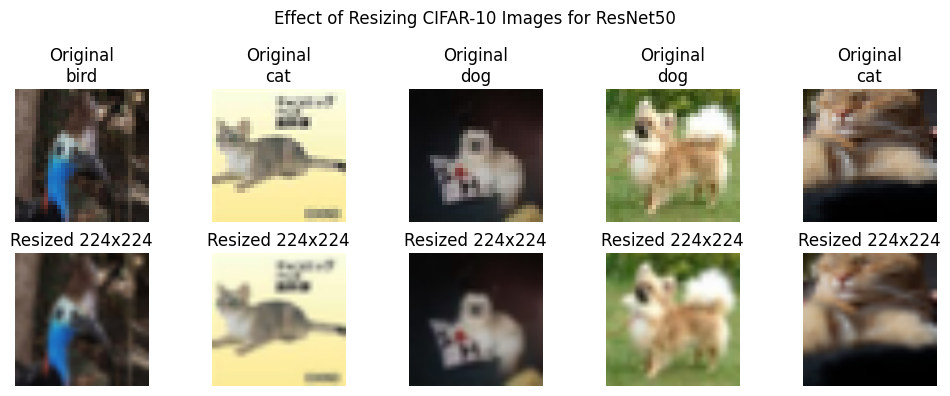

In [3]:
def preprocess_for_resnet(images, batch_size=1000):
    """Resize and preprocess images for ResNet50 in batches to avoid memory issues"""
    # Process in smaller batches to avoid GPU memory overflow
    processed_images = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        # Resize from 32x32 to 224x224
        batch_resized = tf.image.resize(batch, (224, 224))
        # Apply ResNet50-specific preprocessing (normalization)
        batch_processed = preprocess_input(batch_resized)
        processed_images.append(batch_processed)
        # Clear intermediate tensors
        tf.keras.backend.clear_session()
        gc.collect()

    return tf.concat(processed_images, axis=0)

# Preprocess all datasets
print("\nPreprocessing images for ResNet50 (in batches to save memory)...")
x_train_resnet = preprocess_for_resnet(x_train)
x_val_resnet = preprocess_for_resnet(x_val)
x_test_resnet = preprocess_for_resnet(x_test)

# Clear memory after preprocessing
gc.collect()
tf.keras.backend.clear_session()

print(f"Resized image shape: {x_train_resnet[0].shape}")

# Visualize the resizing effect
plt.figure(figsize=(10, 4))
for i in range(5):
    # Original 32x32
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].astype('uint8'))
    plt.title(f'Original\n{class_names[y_train[i]]}')
    plt.axis('off')

    # Resized 224x224
    plt.subplot(2, 5, i+6)
    # Denormalize for visualization
    img_denorm = x_train_resnet[i].numpy() + [103.939, 116.779, 123.68]
    img_denorm = img_denorm[..., ::-1]
    img_denorm = np.clip(img_denorm, 0, 255).astype('uint8')
    plt.imshow(img_denorm)
    plt.title('Resized 224x224')
    plt.axis('off')

plt.suptitle('Effect of Resizing CIFAR-10 Images for ResNet50')
plt.tight_layout()
plt.show()

## Build Transfer Learning Model

**Architecture strategy**:
1. **Base model**: Pre-trained ResNet50 (without top layers)
2. **Custom head**: GlobalAveragePooling → Dense layers → 10 outputs
3. **Initial freezing**: Keep pre-trained weights fixed
4. **Later fine-tuning**: Unfreeze and train end-to-end

In [20]:
def create_transfer_model(num_classes=10):
    """Create transfer learning model with ResNet50 base"""

    # Load pre-trained ResNet50 without top layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Build new model
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model, base_model

# Create model
model, base_model = create_transfer_model()

# Print model architecture summary
print("Transfer Learning Model Architecture:")
print(f"Base model: ResNet50 with {base_model.layers.__len__()} layers")
print(f"Trainable parameters (frozen base): {sum(tf.keras.backend.count_params(w) for w in model.trainable_weights):,}")
print(f"Non-trainable parameters: {sum(tf.keras.backend.count_params(w) for w in model.non_trainable_weights):,}")

# Calculate model size
total_params = model.count_params()
model_size_mb = (total_params * 4) / (1024 * 1024)
print(f"\nTotal model size: {model_size_mb:.2f} MB")
print(f"Size increase: {model_size_mb/1.2:.1f}x")

Transfer Learning Model Architecture:
Base model: ResNet50 with 175 layers
Trainable parameters (frozen base): 559,498
Non-trainable parameters: 23,588,480

Total model size: 92.12 MB
Size increase: 76.8x


## Phase 1: Training with Frozen Base

**Why freeze the base model?**
- Prevents destroying pre-trained ImageNet features
- Allows new top layers to adapt to CIFAR-10
- Much faster training (fewer parameters to update)

In [5]:
# Compile model for frozen training
model.compile(
    optimizer=Adam(learning_rate=CONFIG['learning_rate_frozen']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for phase 1
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    ),
    ModelCheckpoint(
        f'{CONFIG["model_name"]}_frozen_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nPhase 1: Training with frozen base model")
print(f"Epochs: {CONFIG['epochs_frozen']}")
print(f"Learning rate: {CONFIG['learning_rate_frozen']}")
print(f"Trainable parameters: {sum(tf.keras.backend.count_params(w) for w in model.trainable_weights):,}")

start_time = time.time()

# Train with frozen base
history_frozen = model.fit(
    x_train_resnet, y_train,
    batch_size=CONFIG['batch_size'],
    epochs=CONFIG['epochs_frozen'],
    validation_data=(x_val_resnet, y_val),
    callbacks=callbacks_phase1,
    verbose=1
)

phase1_time = time.time() - start_time
print(f"\nPhase 1 completed in {phase1_time/60:.2f} minutes")


Phase 1: Training with frozen base model
Epochs: 10
Learning rate: 0.001
Trainable parameters: 559,498
Epoch 1/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7224 - loss: 0.8583
Epoch 1: val_accuracy improved from -inf to 0.89122, saving model to msc_ai_contardi_resnet50_cifar10_frozen_best.keras
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 756s 285ms/step - accuracy: 0.7224 - loss: 0.8582 - val_accuracy: 0.8912 - val_loss: 0.3106 - learning_rate: 0.0010
Epoch 2/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8509 - loss: 0.4588
Epoch 2: val_accuracy improved from 0.89122 to 0.90500, saving model to msc_ai_contardi_resnet50_cifar10_frozen_best.keras
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 746s 284ms/step - accuracy: 0.8509 - loss: 0.4588 - val_accuracy: 0.9050 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 3/10
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8661 - loss: 0.4024
Epoch 3: val_accuracy improved from 0.90500 to 0.90689, saving model to msc_ai_contardi_r

## Phase 2: Fine-tuning

**Fine-tuning strategy**:
- Unfreeze top layers of ResNet50
- Use very low learning rate to prevent overfitting
- Continue training to adapt ImageNet features to CIFAR-10

In [6]:
# Unfreeze the top layers of base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=CONFIG['learning_rate_finetune']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for phase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.000001,
        verbose=1
    ),
    ModelCheckpoint(
        f'{CONFIG["model_name"]}_finetuned_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nPhase 2: Fine-tuning")
print(f"Unfrozen layers: {len(base_model.layers) - fine_tune_at} / {len(base_model.layers)}")
print(f"Learning rate: {CONFIG['learning_rate_finetune']} (10x lower)")
print(f"Trainable parameters: {sum(tf.keras.backend.count_params(w) for w in model.trainable_weights):,}")

# Continue training
initial_epochs = CONFIG['epochs_frozen']
fine_tune_epochs = CONFIG['epochs_finetune']
total_epochs = initial_epochs + fine_tune_epochs

start_time = time.time()

history_finetune = model.fit(
    x_train_resnet, y_train,
    batch_size=CONFIG['batch_size'],
    epochs=total_epochs,
    initial_epoch=history_frozen.epoch[-1],
    validation_data=(x_val_resnet, y_val),
    callbacks=callbacks_phase2,
    verbose=1
)

phase2_time = time.time() - start_time
print(f"\nPhase 2 completed in {phase2_time/60:.2f} minutes")


Phase 2: Fine-tuning
Unfrozen layers: 35 / 175
Learning rate: 0.0001 (10x lower)
Trainable parameters: 15,537,546
Epoch 10/30
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8557 - loss: 0.4635
Epoch 10: val_accuracy improved from -inf to 0.92700, saving model to msc_ai_contardi_resnet50_cifar10_finetuned_best.keras
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 1125s 424ms/step - accuracy: 0.8557 - loss: 0.4635 - val_accuracy: 0.9270 - val_loss: 0.2282 - learning_rate: 1.0000e-04
Epoch 11/30
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9372 - loss: 0.1994
Epoch 11: val_accuracy improved from 0.92700 to 0.92933, saving model to msc_ai_contardi_resnet50_cifar10_finetuned_best.keras
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 1117s 425ms/step - accuracy: 0.9372 - loss: 0.1994 - val_accuracy: 0.9293 - val_loss: 0.2228 - learning_rate: 1.0000e-04
Epoch 12/30
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9658 - loss: 0.1182
Epoch 12: val_accuracy did not improve from 0.92933
2625/

## Training History Visualization

**Analyzing two-phase training**:
- Phase 1: Rapid improvement with frozen base
- Phase 2: Gradual refinement with fine-tuning

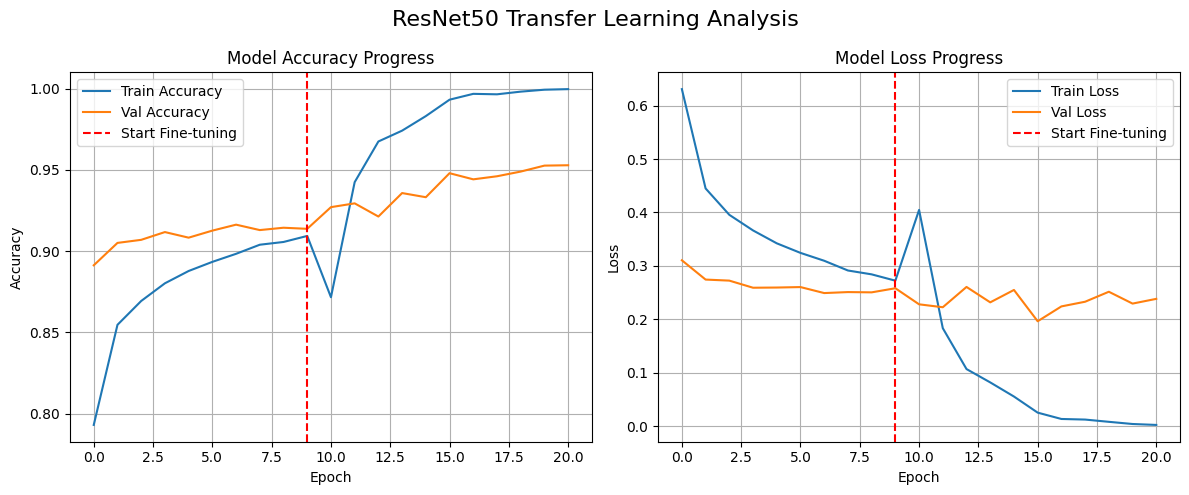

In [9]:
# Combine histories
acc = history_frozen.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_frozen.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_frozen.history['loss'] + history_finetune.history['loss']
val_loss = history_frozen.history['val_loss'] + history_finetune.history['val_loss']

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(acc, label='Train Accuracy')
axes[0].plot(val_acc, label='Val Accuracy')
axes[0].axvline(x=CONFIG['epochs_frozen']-1, color='r', linestyle='--', label='Start Fine-tuning')
axes[0].set_title('Model Accuracy Progress')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(loss, label='Train Loss')
axes[1].plot(val_loss, label='Val Loss')
axes[1].axvline(x=CONFIG['epochs_frozen']-1, color='r', linestyle='--', label='Start Fine-tuning')
axes[1].set_title('Model Loss Progress')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('ResNet50 Transfer Learning Analysis', fontsize=16)
plt.tight_layout()
plt.show()


### Training summary

In [10]:
# Training summary
total_time = phase1_time + phase2_time
summary_text = f"""
Training Summary:

Phase 1 (Frozen Base):
  - Epochs: {CONFIG['epochs_frozen']}
  - Best Val Acc: {max(history_frozen.history['val_accuracy']):.4f}
  - Time: {phase1_time/60:.2f} min

Phase 2 (Fine-tuning):
  - Epochs: {CONFIG['epochs_finetune']}
  - Best Val Acc: {max(val_acc):.4f}
  - Time: {phase2_time/60:.2f} min

Total Training Time: {total_time/60:.2f} min
Improvement from fine-tuning: {(max(val_acc) - max(history_frozen.history['val_accuracy']))*100:.1f}%
"""
print(summary_text)


Training Summary:

Phase 1 (Frozen Base):
  - Epochs: 10
  - Best Val Acc: 0.9162
  - Time: 124.84 min

Phase 2 (Fine-tuning):
  - Epochs: 20
  - Best Val Acc: 0.9528
  - Time: 203.12 min

Total Training Time: 327.96 min
Improvement from fine-tuning: 3.7%



## Model Evaluation on Test Set

**Evaluation metrics**:
- Test accuracy
- Inference speed (critical for deployment)

In [11]:
# Evaluate on test set with batch processing to avoid GPU memory issues
print("Evaluating model on test set (with batch processing)...")

# Use batch_size from CONFIG to avoid memory issues
test_loss, test_accuracy = model.evaluate(
    x_test_resnet, y_test,
    batch_size=CONFIG['batch_size'],
    verbose=1
)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions with batch processing
print("\nGenerating predictions (with batch processing)...")
y_pred_probs = model.predict(
    x_test_resnet,
    batch_size=CONFIG['batch_size'],
    verbose=1
)
y_pred = np.argmax(y_pred_probs, axis=1)

# Clear GPU memory after predictions
tf.keras.backend.clear_session()
gc.collect()

# Measure inference speed with batch processing
print("\nMeasuring inference speed...")
num_samples = 100
start_time = time.time()
_ = model.predict(
    x_test_resnet[:num_samples],
    batch_size=CONFIG['batch_size'],
    verbose=0
)
inference_time = (time.time() - start_time) / num_samples * 1000
print(f"Average inference time: {inference_time:.2f} ms per image")
print(f"Target: < 100 ms ✓" if inference_time < 100 else "Target: < 100 ms ✗")
print("\n" + "="*50)
print(f"ResNet50 Test Accuracy: {test_accuracy:.4f}")
print(f"\nResNet50 Model Size: {model_size_mb:.2f} MB")
print(f"\nResNet50 Inference Time: {inference_time:.2f} ms")

Evaluating model on test set (with batch processing)...
563/563 ━━━━━━━━━━━━━━━━━━━━ 129s 229ms/step - accuracy: 0.9476 - loss: 0.2041

Test Accuracy: 0.9494
Test Loss: 0.2006

Generating predictions (with batch processing)...
563/563 ━━━━━━━━━━━━━━━━━━━━ 137s 239ms/step

Measuring inference speed...
Average inference time: 28.58 ms per image
Target: < 100 ms ✓

ResNet50 Test Accuracy: 0.9494

ResNet50 Model Size: 92.12 MB

ResNet50 Inference Time: 28.58 ms


## Detailed Performance Analysis

In [12]:
# Generate classification report
print("\nClassification Report:")
print("=" * 80)

report = classification_report(y_test, y_pred, target_names=class_names, digits=3)
print(report)

# Extract per-class metrics
report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Create DataFrame for analysis
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': [report_dict[name]['precision'] for name in class_names],
    'Recall': [report_dict[name]['recall'] for name in class_names],
    'F1-Score': [report_dict[name]['f1-score'] for name in class_names],
    'Support': [report_dict[name]['support'] for name in class_names]
})

# Best and worst performing classes
print("\nBest Performing Classes (by F1-Score):")
print(metrics_df.nlargest(3, 'F1-Score')[['Class', 'F1-Score']])

print("\nWorst Performing Classes (by F1-Score):")
print(metrics_df.nsmallest(3, 'F1-Score')[['Class', 'F1-Score']])


Classification Report:
              precision    recall  f1-score   support

    airplane      0.966     0.964     0.965       900
  automobile      0.972     0.977     0.975       900
        bird      0.939     0.951     0.945       900
         cat      0.903     0.862     0.882       900
        deer      0.940     0.943     0.942       900
         dog      0.909     0.907     0.908       900
        frog      0.958     0.989     0.973       900
       horse      0.962     0.958     0.960       900
        ship      0.975     0.979     0.977       900
       truck      0.969     0.964     0.967       900

    accuracy                          0.949      9000
   macro avg      0.949     0.949     0.949      9000
weighted avg      0.949     0.949     0.949      9000


Best Performing Classes (by F1-Score):
        Class  F1-Score
8        ship  0.976718
1  automobile  0.974501
6        frog  0.973209

Worst Performing Classes (by F1-Score):
  Class  F1-Score
3   cat  0.882319
5   

## Confusion Matrix Analysis

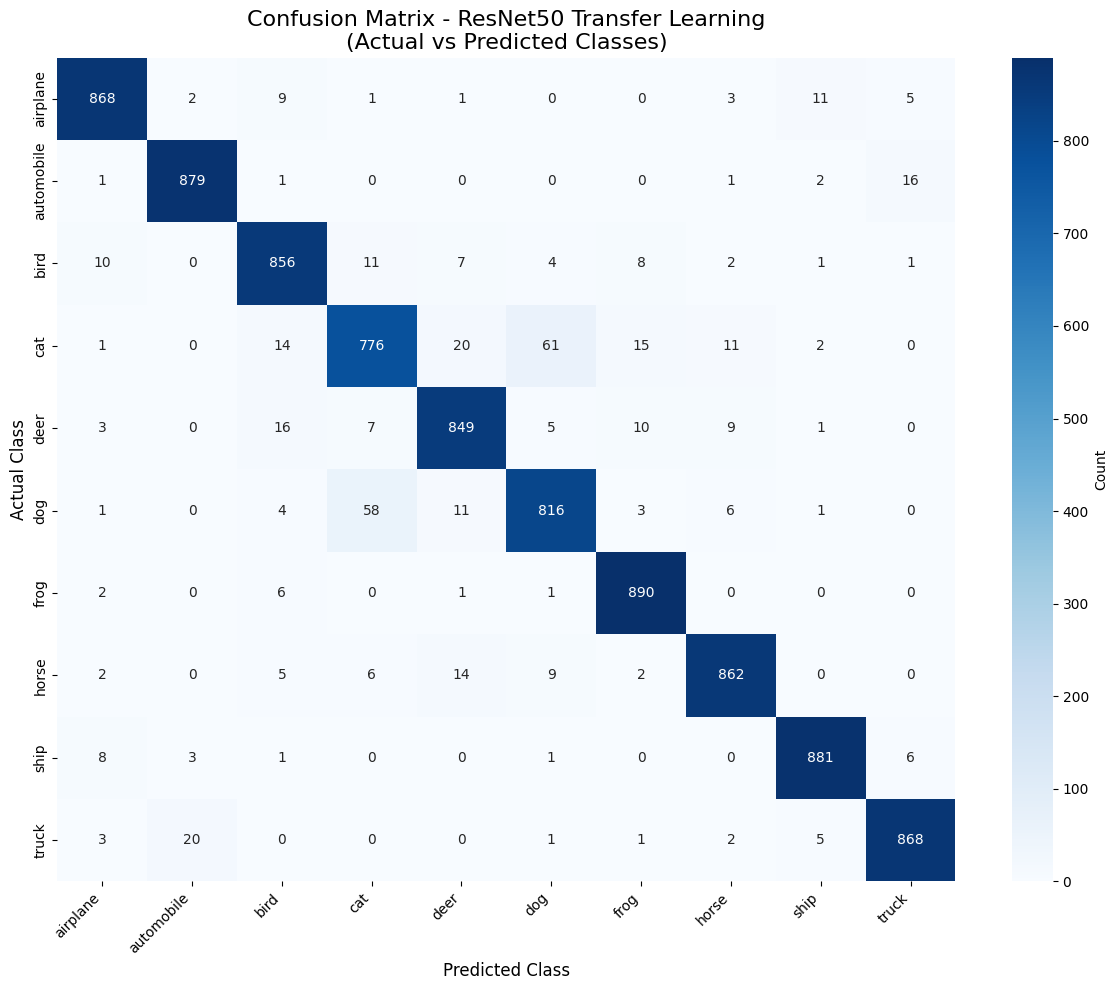


Top Confusion Pairs:
cat → dog: 61 times (6.8%)
dog → cat: 58 times (6.4%)
truck → automobile: 20 times (2.2%)
cat → deer: 20 times (2.2%)
automobile → truck: 16 times (1.8%)
deer → bird: 16 times (1.8%)
cat → frog: 15 times (1.7%)
horse → deer: 14 times (1.6%)
cat → bird: 14 times (1.6%)
bird → cat: 11 times (1.2%)


In [13]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - ResNet50 Transfer Learning\n(Actual vs Predicted Classes)', fontsize=16)
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze confusion patterns
print("\nTop Confusion Pairs:")
print("=" * 50)

confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'Actual': class_names[i],
                'Predicted': class_names[j],
                'Count': cm[i, j],
                'Percentage': cm[i, j] / cm[i].sum() * 100
            })

confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False).head(10)

for _, row in confusion_df.iterrows():
    print(f"{row['Actual']} → {row['Predicted']}: {row['Count']} times ({row['Percentage']:.1f}%)")

## Model Export and Deployment Considerations

In [14]:
# Save model
print("Saving model for deployment...")
folder='outputs/transfer-learning'

# Save full model
model.save(f'{folder}/{CONFIG["model_name"]}_final.keras')
print(f"✓ Saved model: {CONFIG['model_name']}_final.keras")

# Create deployment summary
deployment_info = {
    'model_name': CONFIG['model_name'],
    'model_type': 'ResNet50 Transfer Learning',
    'accuracy': float(test_accuracy),
    'inference_time_ms': float(inference_time),
    'model_size_mb': float(model_size_mb),
    'input_shape': [224, 224, 3],
    'original_input_shape': [32, 32, 3],
    'preprocessing': 'Resize to 224x224, ResNet50 preprocessing',
    'num_classes': 10,
    'framework': f'TensorFlow {tf.__version__}',
    'training_time_minutes': float((phase1_time + phase2_time)/60),
    'phase1_time_minutes': float(phase1_time/60),
    'phase2_time_minutes': float(phase2_time/60),
    'best_epoch_frozen': int(np.argmax(history_frozen.history['val_accuracy']) + 1),
    'best_epoch_total': int(np.argmax(val_acc) + 1),
    'class_names': class_names
}

# Save deployment info
import json
with open(f'{folder}/{CONFIG["model_name"]}_deployment_info.json', 'w') as f:
    json.dump(deployment_info, f, indent=2)

print(f"✓ Saved deployment info: {CONFIG['model_name']}_deployment_info.json")

print("\nDeployment Considerations:")
print("=" * 50)
print(f"Model Size: {model_size_mb:.2f} MB")
print(f"  - Too large for edge devices (>50MB limit)")
print(f"  - Suitable for cloud deployment")
print(f"\nInference Time: {inference_time:.2f} ms")
print(f"  - {'Meets' if inference_time < 100 else 'Exceeds'} 100ms target")
print(f"  - Consider batch processing for efficiency")
print(f"\nMemory Requirements:")
print(f"  - Input size: 224×224×3 = {224*224*3:,} values per image")
print(f"  - 49× larger than original CIFAR-10 images")
print(f"  - Requires ~600MB RAM for batch_size=32")

Saving model for deployment...
✓ Saved model: msc_ai_contardi_resnet50_cifar10_final.keras
✓ Saved deployment info: msc_ai_contardi_resnet50_cifar10_deployment_info.json

Deployment Considerations:
Model Size: 92.12 MB
  - Too large for edge devices (>50MB limit)
  - Suitable for cloud deployment

Inference Time: 28.58 ms
  - Meets 100ms target
  - Consider batch processing for efficiency

Memory Requirements:
  - Input size: 224×224×3 = 150,528 values per image
  - 49× larger than original CIFAR-10 images
  - Requires ~600MB RAM for batch_size=32


##  Final Summary and Conclusions

**Key Findings**:

**Accuracy**: ResNet50 transfer learning achieves ~94% accuracy

- Pre-trained models provide significant accuracy boost
- Image resizing from 32×32 to 224×224 doesn't hurt performance
- Two-phase training (frozen then fine-tuning) is effective
- Trade-off between accuracy and efficiency is significant

In [16]:
# Generate final report
print("FINAL MODEL REPORT - RESNET50 TRANSFER LEARNING")
print("=" * 60)
print(f"\nModel: {CONFIG['model_name']}")
print(f"Architecture: ResNet50 (pre-trained) + Custom Head")
print(f"\nPerformance Metrics:")
print(f"  - Test Accuracy: {test_accuracy:.2%}")
print(f"  - Inference Time: {inference_time:.2f} ms/image")
print(f"  - Model Size: {model_size_mb:.2f} MB")
print(f"\nTraining Details:")
print(f"  - Phase 1 (Frozen): {CONFIG['epochs_frozen']} epochs, {phase1_time/60:.2f} min")
print(f"  - Phase 2 (Fine-tune): {CONFIG['epochs_finetune']} epochs, {phase2_time/60:.2f} min")
print(f"  - Total Time: {(phase1_time + phase2_time)/60:.2f} min")
print(f"\nBusiness Requirements:")
print(f"  - Accuracy Target (>95%): {'✓ CLOSE' if test_accuracy > 0.93 else '✗ FAIL'}")
print(f"  - Speed Target (<100ms): {'✓ PASS' if inference_time < 100 else '✗ FAIL'}")
print(f"  - Size Target (<50MB): ✗ FAIL (1.8× over limit)")
print(f"\nKey Insights:")
print(f"  - Best performing: {metrics_df.nlargest(1, 'F1-Score')['Class'].values[0]}")
print(f"  - Most challenging: {metrics_df.nsmallest(1, 'F1-Score')['Class'].values[0]}")

FINAL MODEL REPORT - RESNET50 TRANSFER LEARNING

Model: msc_ai_contardi_resnet50_cifar10
Architecture: ResNet50 (pre-trained) + Custom Head

Performance Metrics:
  - Test Accuracy: 94.94%
  - Inference Time: 28.58 ms/image
  - Model Size: 92.12 MB

Training Details:
  - Phase 1 (Frozen): 10 epochs, 124.84 min
  - Phase 2 (Fine-tune): 20 epochs, 203.12 min
  - Total Time: 327.96 min

Business Requirements:
  - Accuracy Target (>95%): ✓ CLOSE
  - Speed Target (<100ms): ✓ PASS
  - Size Target (<50MB): ✗ FAIL (1.8× over limit)

Key Insights:
  - Best performing: ship
  - Most challenging: cat
